## 边缘检测

什么是边缘：

* 图像中像素值发生剧烈变化的位置(高频信息区域)

* 这些区域往往都是图像的边缘


### 目前已经涉及的边缘检测方法

* 滤波

* 形态学处理
    

### 边缘有什么用

本质上，边缘是不同区域之间的边界。

其中包含了图像的区域信息，形状信息

一方面，可以利用这些信息来作为特征对图像进行理解(甚至深度学习中也有应用)

另一方面，事先提取出这些信息加以保存，以避免在一些操作中将边缘信息抹除

### 成熟的边缘检测算法--canny


canny算法是目前为止接触的最复杂的算法之一。

他具有很多的前后处理优化细节，可以得到更好的边缘检测结果。

总的来说，他的基本原理是：在图像中寻找局部最大梯度，将非最大值梯度抑制和双阈值处理结合，产生好的边缘检测结果。

#### 提出动机

canny算法之前，边缘提取方法长期受困于噪声影响。

噪声，会使得图像中的像素值产生随机变化，从而使得边缘检测的结果出现错误或者不准确。

而canny采用以下方法来抑制噪声

1. 引入高斯滤波器，来平滑噪声

2. 采用非最大值抑制来抑制边缘响应，对于边缘宽度的变化更加敏感

3. 采用两段阈值方法处理，从噪声中分离边缘

#### 具体步骤

- 高斯滤波
- 计算梯度幅值和方向
- 非最大值抑制
- 双阈值处理
- 边缘连接

#### 底层实现

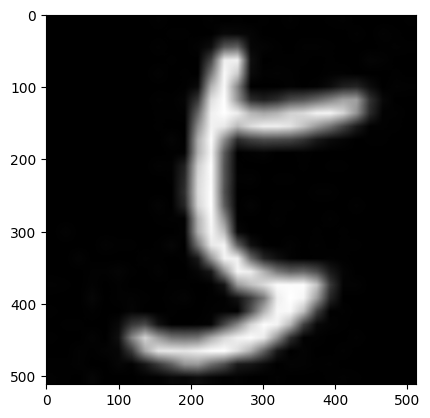

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../../dataset/5.jpg", 0)
img = cv2.resize(img, (512, 512))

plt.imshow(img, cmap='gray')
plt.show()

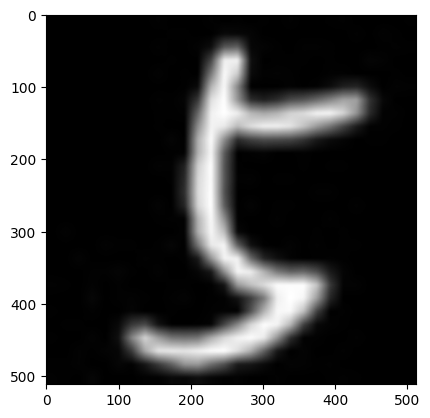

In [31]:
# 高斯滤波平滑
blur = cv2.GaussianBlur(img, (5, 5), 2)
plt.imshow(blur, cmap='gray')
plt.show()

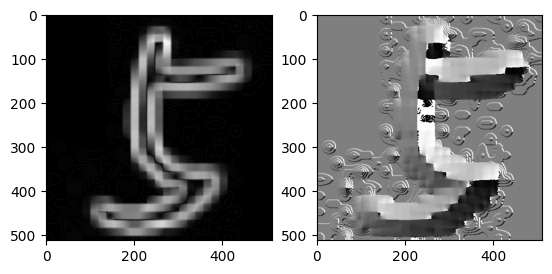

In [32]:
# Sobel算子计算梯度和方向
sobel_x = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)
mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
direction = np.arctan2(sobel_y, sobel_x) * 180 / np.pi

plt.subplot(1, 2, 1)
plt.imshow(mag, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(direction, cmap='gray')
plt.show()

#### 非极大值抑制nms

任意一个点，对于其梯度方向的前一个值与后一个值进行比较。

如果不是最大的，就置为0

否则，不变。

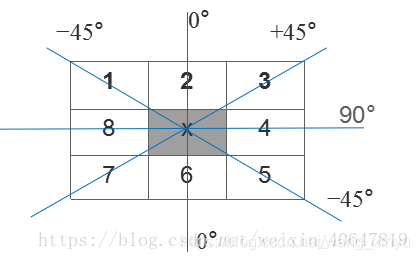

其目的在于，将宽的边缘减少为1个像素

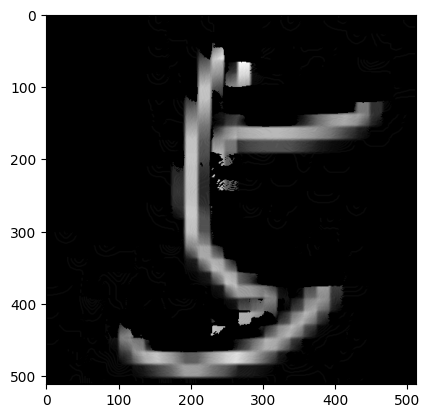

In [48]:
rows, cols = noise_img.shape
nms = np.zeros((rows, cols), dtype=np.float32)
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if (0 <= direction[i, j] < 22.5) or (157.5 <= direction[i, j] <= 180):
            a1, b1 = i+1, j
            a2, b2 = i-1, j
        elif 22.5 <= direction[i, j] < 67.5:
            a1, b1 = i+1, j+1
            a2, b2 = i-1, j-1
        elif 67.5 <= direction[i, j] < 112.5:
            a1, b1 = i, j+1
            a2, b2 = i, j-1
        else:
            a1, b1 = i+1, j-1
            a2, b2 = i-1, j+1
        if mag[i, j] >= direction[a1, b1] and mag[i, j] >= direction[a2, b2]:
            nms[i, j] = mag[i, j]
            
plt.imshow(nms, cmap='gray')
plt.show()

**双阈值处理**

设定一个上限和下限

如果nsm中的内容小于下限，则值为零，目的在去除噪声

如果nms中的内容大于上限，则值为255， 目的在于强化边缘

如果一个像素值处于上下限之间，但如果周围

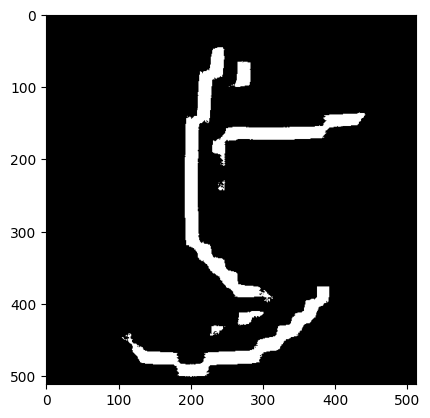

In [46]:
# 双阈值处理
edge_img = np.zeros_like(noise_img)
h, w = edge_img.shape

tl = 50
th = 100
k = 8

for i in range(1, h-1):
    for j in range(1, w-1):
        if nms[i, j] < tl:
            edge_img[i, j] = 0
        elif nms[i, j] > th:
            edge_img[i, j] = 255
        else:
            tmp = nms[i-k: i+k, j-k:j+k]
            if (tmp < th).any():
                edge_img[i, j] = 255
            else:
                edge_img[i, j] = 0
                
plt.imshow(edge_img, cmap='gray')
plt.show()

### 上述结果只为演示canny计算的过程，其结果和官方提供的函数并不一致，主要是参数的设置问题。


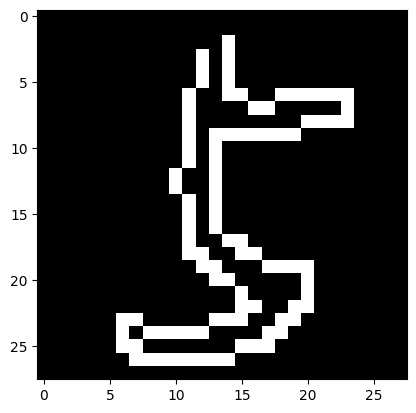

In [55]:
img = cv2.imread("../../dataset/5.jpg", 0)
edges = cv2.Canny(img, 50, 100)

plt.imshow(edges, cmap='gray')
plt.show()

### 连通区域分析

如何填补边缘中间的内容？

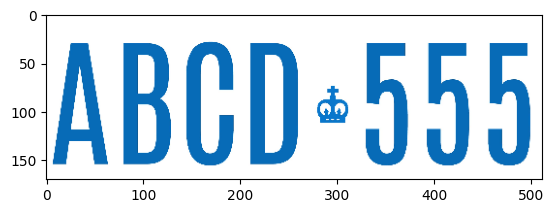

In [80]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('../../dataset/car.jpg')[670:-570, 370:-370, :]
img = cv2.resize(img, [512, int(512 * img.shape[0] / img.shape[1])])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

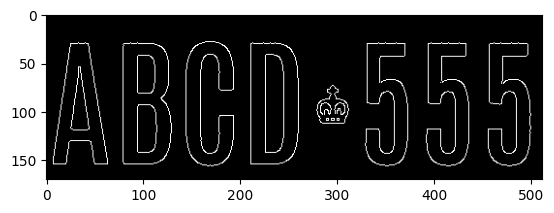

In [81]:
edges = cv2.Canny(img, 50, 100)
plt.imshow(edges, cmap='gray')
plt.show()

从图像左上角开始扫描，对每个像素：
    
    - 如果为前景像素，则会从同一行的前面，或上一行的后面选择标号最小的进行标记
    - 如果没有找到已标记的连通区域，则会单独标记

In [91]:
output = cv2.connectedComponents(edges, 4)

输出结果中，为图像数量和连通区域标签。

例如：

In [93]:
print("连通区域数量：", output[0])

连通区域数量： 19


In [94]:
print("连通区域的标签形状：", output[1].shape, "最大标签：", output[1].max())

连通区域的标签形状： (170, 512) 最大标签： 18


要展示出不同的连通区域，可按照下述步骤进行

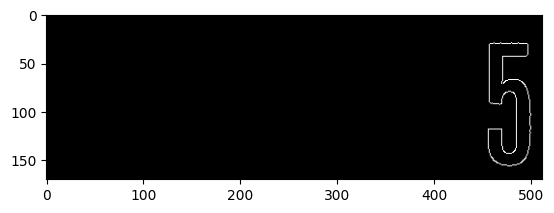

In [101]:
mask = np.zeros_like(output[1])

mask[output[1] == 7] = 255

plt.imshow(mask, cmap='gray')
plt.show()

除了上述的连通区域分析之外，还可以通过其他函数实现。

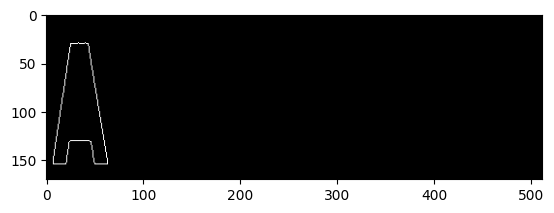

In [112]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges)
result = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

result[labels==1] = 255
plt.imshow(result, cmap='gray')
plt.show()

同样，可以通过floodfill来实现连通区域内的填充。

(170, 512, 3)


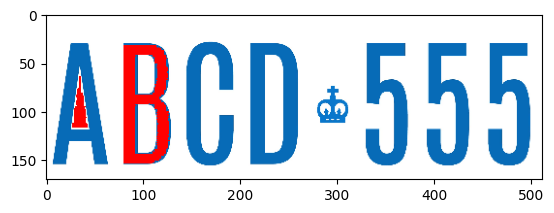

In [123]:
dst = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=np.uint8)
seed = (int(centroids[2][0]), int(centroids[2][1]))
colored = cv2.floodFill(img, dst, seed, 255)

print(colored[1].shape)
plt.imshow(colored[1], cmap='gray')
plt.show()

### 练习：将下图重新着色

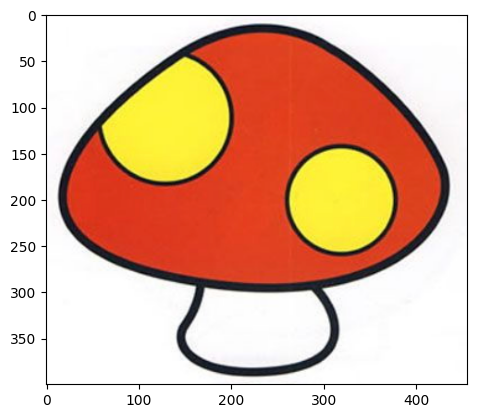

In [126]:
import cv2

image = cv2.imread("../../dataset/3c.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

上图中的颜色对应关系：

背景：白色 -> (0, 0, 0)
边缘：黑色 -> (0, 255, 128)
伞帽: 红色 -> (128, 255, 0)
伞斑：黄色 -> (0, 0, 128)
伞柄：白色 -> (255, 0, 128)